<img src="cryotempo_logo.png" alt="logo" width="200"/> <img src="esa_logo.png" alt="esa" width="170"/> <img src="earthwave_logo.png" alt="earthwave" width="150"/> <img src="UoE_logo.png" alt="uoe" width="200"/>

##<strong>*This is a Jupyter notebook that demonstrates how to download and use Cryotempo-EOLIS data, downloaded from cs2eo.org. Here, we will read in some gridded data and then plot DEMs*</strong> 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

To run this notebook, you will need to make sure that the folllowing packages are installed in your python environment (all can be installed via pip/conda)

    - matplotlib
    - pandas: for dataframe manipulation
    - netCDF4: for handing NetCDF files
    - glob
    - datetime: for handling timestamps
    - numpy
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [ ]:
!pip install netCDF4

###<strong>1) Download Data:

Regardless of whether you are using the Google Colab environment, or have downloaded this notebook to your local drive, you will first need to download some data. You can use this notebook to plot any CryoTEMPO-EOLIS gridded data that you choose. For a quick example, follow the below instructions to download a small example dataset.</strong>

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

Imports necessary to run the rest of the code

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import glob
import numpy as np
import datetime
import os
from ftplib import FTP

plt.rcParams.update({'font.size': 14})

<strong>The following four cells contain the python script necessary to download the results of the query described above from the ESA FTP servers. It is taken verbatim from the script generated by a cs2eo query - one could run said script in place of these 4 cells, for any query of your choice. The data is downloaded to your current working directory. This query will download a file containing gridded product data for Vatnajokull.</strong>

This function is necessary to complete the data download

In [2]:
def file_byte_handler(data):
    global download_file_obj, read_byte_count, total_byte_count
    download_file_obj.write(data)
    read_byte_count = read_byte_count + len(data)

First, we list the files that we want to download. These are generated automatically by a [cs2eo.org](https://cs2eo.org/cryotempo) query. If you wanted to download additional months or a different region, you would add the corresponding file paths to this list.

In [3]:
esa_files =  ['/TEMPO_SWATH_GRID/2022/12/ICELAND/CS_OFFL_THEM_GRID__ICELAND___2022_12_V201.nc']
download_file_obj = None
read_byte_count = None
total_byte_count = None

Next, we must provide an email address to access the ESA FTP server. Input your email into the prompt that appears below.

In [4]:
email = input("Please enter your e-mail: ")

Finally, we connect to the server, supply our email address and download the data to our current working directory. This process should take a couple of minutes. The progress of the download will be shown below.

In [5]:
print("About to connect to ESA science server")
# Open the FTP connection
with FTP("science-pds.cryosat.esa.int") as ftp:
    try:
        #Login using your email address
        ftp.login("anonymous", email)
        print("Downloading {} files".format(len(esa_files)))
        # Step through the files that we want to download    
        for i, filename in enumerate(esa_files):
            padded_count = str(i+1).zfill(len(str(len(esa_files))))
            # Print some details about the progress of the download
            print("{}/{}. Downloading file {}".format(padded_count, len(esa_files), os.path.basename(filename)))
            with open(os.path.basename(filename), 'wb') as download_file:
                download_file_obj = download_file
                total_byte_count = ftp.size(filename)
                read_byte_count = 0
                ftp.retrbinary('RETR ' + filename, file_byte_handler, 1024)
            print("\n")
    # After downloading all of the files, close the FTP connection
    finally:
        print("Exiting FTP.")
        ftp.quit()

About to connect to ESA science server
1/1. Downloading file CS_OFFL_THEM_GRID__ANTARCTIC_2019_02_V001.nc


Exiting FTP.


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
###<strong>2) Load downloaded data into python</strong>

<strong>Now that we have downloaded the data, we can use python to visualise it. In the remainder of this demo notebook, we will load the data that we have just downloaded into python, and then use it to plot a series of DEMs showing the elevation of the Vatnajokull glacier.</strong> 

If you have downloaded the notebook onto your local machine, you will need to edit the filepath below to point to the location of the downloaded data. We will then locate and store the names of each of the gridded data files. The gridded data is stored in *netcdf* files, which have the suffix '.nc'.
Here, we also define the coordinate reference system (CRS) for the region that we are plotting (Iceland), that describes the projection information for this geographical area. If you wish to plot a different region, you may need to change the CRS definition to match the region, as described at https://cryotempo-eolis.org/products/

In [3]:
region = 'ICELAND'
data_filepath = '/content/' #Filepath specific to the Google Colab environment - edit this is you are running the notebook on your local system
region_crs = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' # Standard projection information for Iceland
files = sorted(glob.glob(data_filepath+f'/*{region}*.nc')) # If you download data for a different region, edit the name provided here

<strong>Now that the files containing the data have been located, we will load the data that they contain into python, one file at a time.</strong>

In [ ]:
dem_list, timestamp_list = [], []

Firstly, we can check the metadata for the gridded product files. In the output of this command, we can see lots of additional information assosciated with the gridded product files, including projection information, product version and support information.

In [8]:
dataset = nc.Dataset(files[0])
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    cdm_data_type: Gridded
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    comment: Gridded file containing elevation estimates on a regular grid
    contact: support@cryotempo-eolis.org
    creator_email: support@cryotempo-eolis.org
    creator_url: http://cryotempo-eolis.org/
    date_created: 2022-02-05T16:03:36.166591
    date_modified: 2022-02-05T16:03:36.166604
    DOI: 10.5270/CR2-2xs4q4l
    geospatial_y_min: -2575000
    geospatial_y_max: -2375000
    geospatial_x_min: 1240000
    geospatial_x_max: 1425000
    geospatial_y_units: metres
    geospatial_x_units: metres
    geospatial_projection: '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'
    geospatial_resolution: 2000
    geospatial_resolution_units: metres
    institution: ESA, UoE, Earthwave, isardSAT
    keywords: Land Ice > Gridded > Elevation Model  

 The following loop opens each netcdf file, reads in the data associated with each variable, and stores this data in the column of a dataframe. Here we choose to extract the x and y positions, and the elevation value, of each gridcell within the gridded product.

In [9]:
for i in range(len(files)):
    # Open the netcdf file
    netcdf = nc.Dataset(files[i])
    # Store the 'time' variable as a list of timestamps
    time =  netcdf.variables['time']
    timestamp_list.append(time[:])
    dem, x_bnds, y_bnds = [], [], []
    # Store data for x, y and elevation in lists
    for v in netcdf.variables:
        d = netcdf.variables[v]
        if v == 'elevation':
            dem.append(d[:])
        elif v == 'x_bnds':
            x_bnds.append(d[:])
        elif v == 'y_bnds':
            y_bnds.append(d[:]) 
    # Set no data values to np.nan           
    dem[0][dem[0].mask] = np.nan 
    # x_bnds and y_bnds contain the boundaries of each gridcell - here we find the midpoint   
    xs = np.average(x_bnds[0].data, axis=1)
    ys = np.average(y_bnds[0].data, axis=1)
    # Create a grid of x and y coordinates
    yy, xx = np.meshgrid(ys, xs)
    df = pd.DataFrame()
    # Store data from netcdf in new dataframe
    df['x'] = xx.flatten()
    df['y'] = yy.flatten()
    df['elevation'] = dem[0].data.reshape(len(xs), len(ys)).flatten()
    
    dem_list.append(df)

Finally, we use the datetime python package to convert the *timestamps* provided by the EOLIS data into *years, months and days*.

In [10]:
dates = [datetime.datetime.fromtimestamp(a[0]) for a in timestamp_list]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
###<strong>3) Use the Cryotempo-EOLIS gridded product to plot a selection of DEMS, and show the difference in elevation for a specific time window</strong>

Below, we plot the 2-dimensional elevation data for the Vatnajokull glacier.

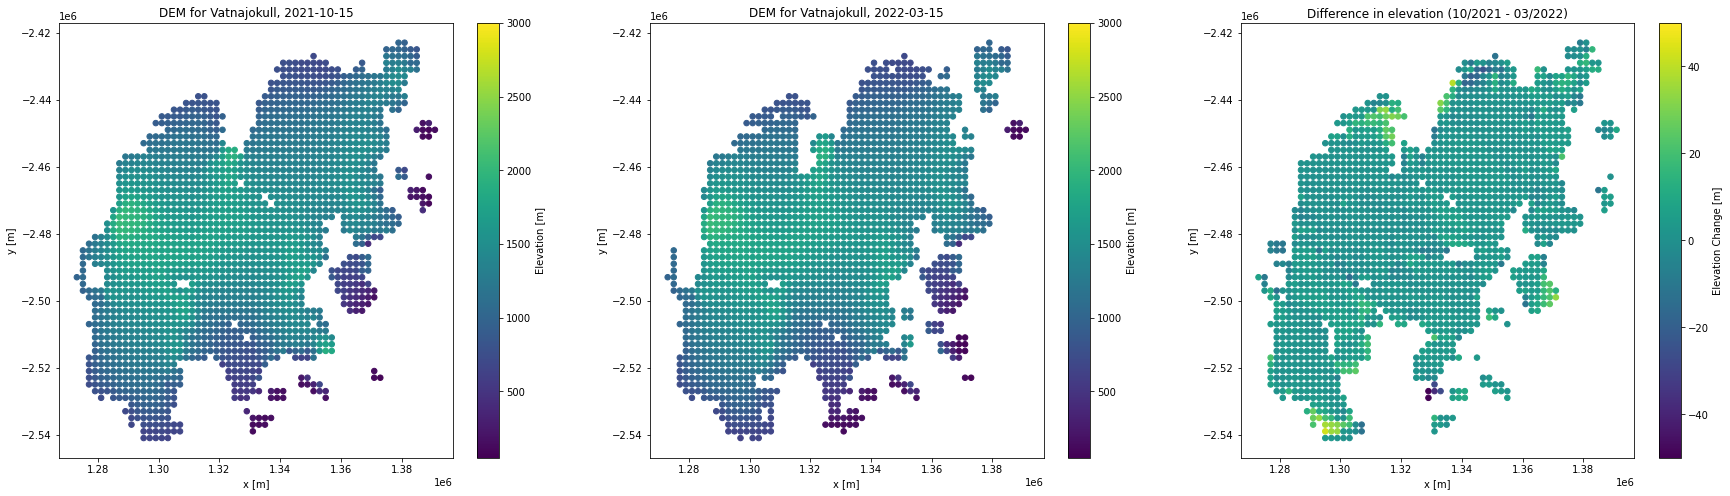

In [11]:
fig, axs = plt.subplots(1,1, figsize=(10, 10))
a=axs.scatter(dem_list[0]['x'], dem_list[0]['y'], c=dem_list[0]['elevation'], s=30, cmap='viridis', vmin = 50, vmax = 3000)
plt.colorbar(a, ax=axs, label='Elevation [m]')
axs.set_title(f'DEM for {region}, {str(dates[0].date())}')

axs.set_xlabel('x [m]')
axs.set_ylabel('y [m]')